### Zadania
 
1. **(1pkt)** Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. Do analizy danych można użyć wybranego narzędzia (Julia, R)
 
 
2. **(2 pkt)** Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy (wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). 
    
    Do analizy danych można użyć wybranego narzędzia (Julia, R)
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 


3. **(1 pkt)** Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. Do analizy danych można użyć wybranego narzędzia (Julia, R)

4. **(1 pkt)** Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. 

5. **(1 pkt)** Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ 


### Zadanie 1
 
**(1pkt)** Uruchomić 
   - naive_multiplication(A,B), 
   - better_multiplication(A,B) 
   - mnożenie BLAS w Julii (A*B) 

   dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. Do analizy danych można użyć wybranego narzędzia (Julia, R)

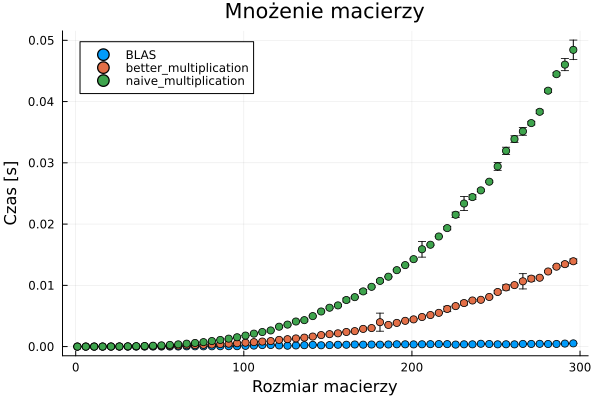

In [ ]:
using DataFrames
using Statistics
using Plots

# Mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

# Poprawiona funkcja
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

# Tablica zawierająca wszystkie rozmiary macierzy, które będziemy testować
matrix_sizes = range(1, stop=300, step=5)

# Liczba pomiarów
num_measurements = 10

# Struktura DataFrame, w którym będziemy zapisywać wyniki po każdym pomiarze
results = DataFrame(matrix_size = Int[], function_name = String[], time = Float64[])

for matrix_size in matrix_sizes
    
    for i in 1:num_measurements+1 # Wykonujemy n+1 pomiarów, a pierwszy pomiar pomijamy (nie uwzględniamy w wynikach)

        A = rand(matrix_size, matrix_size)
        B = rand(matrix_size, matrix_size)

        naive_multiplication_time = (@timed naive_multiplication(A, B)).time
        better_multiplication_time = (@timed better_multiplication(A, B)).time
        BLAS_time = (@timed A*B).time

        if i != 1 # Pierwszy pomiar pomijamy
            push!(results, (matrix_size, "naive_multiplication", naive_multiplication_time))
            push!(results, (matrix_size, "better_multiplication", better_multiplication_time))
            push!(results, (matrix_size, "BLAS", BLAS_time))
        end
    end
end

# Korzystając z mechanizmów DataFrame, grupujemy dane po rozmiarze macierzy i nazwie funkcji
results_grouped = groupby(results, [:matrix_size, :function_name])

# Obliczamy średną i odchylenie standardowe
results_combined = combine(results_grouped, "time" => mean, "time" => var)

# Rysujemy wykres ze słupkami błędów, podpisanymi osiami i tytułami
scatter(
    results_combined.matrix_size,
    results_combined.time_mean,
    group=results_combined.function_name,
    yerr=map(sqrt, results_combined.time_var),
    xlabel="Rozmiar macierzy",
    ylabel="Czas [s]",
    title="Mnożenie macierzy")


### Zadanie 2
 
**(2 pkt)** Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy (wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
   Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). 
    
   Do analizy danych można użyć wybranego narzędzia (Julia, R)
    
   *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 

```c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <gsl/gsl_blas.h>

int n;

// Mnożenie macierzy - wersja naiwna
void naive_multiplication(double A[][n], double B[][n], double C[][n]) {

    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {

            C[i][j] = 0;

            for (int k = 0; k < n; k++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

// Ulepszona wersja
void better_multiplication(double A[][n], double B[][n], double C[][n]) {

    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            C[i][j] = 0;
        }
    }

    for (int i = 0; i < n; i++) {
        for (int k = 0; k < n; k++) {
            for (int j = 0; j < n; j++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

// BLAS
void blas(double a[n*n], double b[n*n], double c[n*n]) {

    gsl_matrix_view A = gsl_matrix_view_array(a, n, n);
    gsl_matrix_view B = gsl_matrix_view_array(b, n, n);
    gsl_matrix_view C = gsl_matrix_view_array(c, n, n);

    gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, &A.matrix, &B.matrix, 0.0, &C.matrix);
}

int main() {

    int num_measurements = 10;

    FILE *fp = fopen("results.csv", "w");
    if (fp == NULL) {
        printf("Error opening file!\n");
        return 1;
    }
    fprintf(fp, "matrix_size,function_name,time\n");

    for (int matrix_size = 1; matrix_size <= 300; matrix_size+=5) {

        n = matrix_size;

        for (int i = 0; i < num_measurements; i++) {

            double a[matrix_size][matrix_size];
            double b[matrix_size][matrix_size];
            double c[matrix_size][matrix_size];
            double a_blas[matrix_size * matrix_size];
            double b_blas[matrix_size * matrix_size];
            double c_blas[matrix_size * matrix_size];

            srand(time(NULL));
            
            for (int i = 0; i < matrix_size; i++) {
                for (int j = 0; j < matrix_size; j++) {
                    a[i][j] = (double) rand() / RAND_MAX;
                    a_blas[i*matrix_size + j] = a[i][j];
                }
            }
            for (int i = 0; i < matrix_size; i++) {
                for (int j = 0; j < matrix_size; j++) {
                    b[i][j] = (double) rand() / RAND_MAX;
                    b_blas[i*matrix_size + j] = b[i][j];
                }
            }
            
            struct timespec naive_start, naive_end;
            clock_gettime(CLOCK_REALTIME, &naive_start);
                naive_multiplication(a, b, c);
            clock_gettime(CLOCK_REALTIME, &naive_end);
            double naive_time = (naive_end.tv_sec - naive_start.tv_sec) + (naive_end.tv_nsec - naive_start.tv_nsec) * 0.000000001;
            fprintf(fp, "%d,%s,%f\n", matrix_size, "naive_multiplication", naive_time);

            struct timespec better_start, better_end;
            clock_gettime(CLOCK_REALTIME, &better_start);
                better_multiplication(a, b, c);
            clock_gettime(CLOCK_REALTIME, &better_end);
            double better_time = (better_end.tv_sec - better_start.tv_sec) + (better_end.tv_nsec - better_start.tv_nsec) * 0.000000001;
            fprintf(fp, "%d,%s,%f\n", matrix_size, "better_multiplication", better_time);

            struct timespec blas_start, blas_end;
            clock_gettime(CLOCK_REALTIME, &blas_start);
                blas(a_blas, b_blas, c_blas);
            clock_gettime(CLOCK_REALTIME, &blas_end);
            double blas_time = (blas_end.tv_sec - blas_start.tv_sec) + (blas_end.tv_nsec - blas_start.tv_nsec) * 0.000000001;
            fprintf(fp, "%d,%s,%f\n", matrix_size, "BLAS", blas_time);
            
        }
    }

    fclose(fp);
    return 0;
}

```

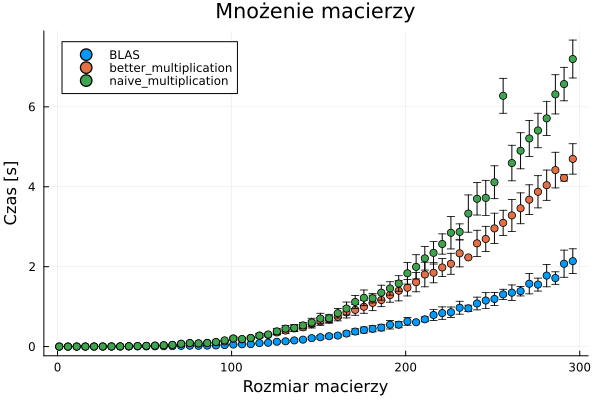

In [ ]:
using DataFrames
using Statistics
using Plots
using CSV

# Wczytujremy dane z pliku CSV
results = CSV.read("results.csv", DataFrame)

# Korzystając z mechanizmów DataFrame, grupujemy dane po rozmiarze macierzy i nazwie funkcji
results_grouped = groupby(results, [:matrix_size, :function_name])

# Obliczamy średną i odchylenie standardowe
results_combined = combine(results_grouped, "time" => mean, "time" => var)

# Rysujemy wykres ze słupkami błędów, podpisanymi osiami i tytułami
scatter(
    results_combined.matrix_size,
    results_combined.time_mean,
    group=results_combined.function_name,
    yerr=map(sqrt, results_combined.time_var),
    xlabel="Rozmiar macierzy",
    ylabel="Czas [s]",
    title="Mnożenie macierzy")


Dłuższy czas wykonania wynika ze zmienienia środowiska uruchomieniowego na znacznie słabsze pod względem mocy obliczeniowej

### Zadanie 3
 
**(1 pkt)** Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. Do analizy danych można użyć wybranego narzędzia (Julia, R)

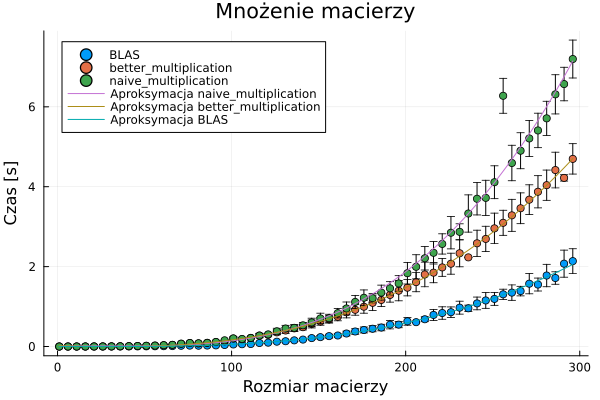

In [ ]:
using Polynomials
using Plots

naive_results = filter(row -> row.function_name == "naive_multiplication", results_combined)
better_results = filter(row -> row.function_name == "better_multiplication", results_combined)
BLAS_results = filter(row -> row.function_name == "BLAS", results_combined)

# Dopasowujemy wielomiany trzeciego stopnia do danych
naive_fit = fit(naive_results.matrix_size, naive_results.time_mean, 3)
better_fit = fit(better_results.matrix_size, better_results.time_mean, 3)
BLAS_fit = fit(BLAS_results.matrix_size, BLAS_results.time_mean, 3)

plot!(naive_fit,  extrema(results_combined.matrix_size)..., label="Aproksymacja naive_multiplication")
plot!(better_fit,  extrema(results_combined.matrix_size)..., label="Aproksymacja better_multiplication")
plot!(BLAS_fit,  extrema(results_combined.matrix_size)..., label="Aproksymacja BLAS")


### Zadanie 4
 
**(1 pkt)** Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres.

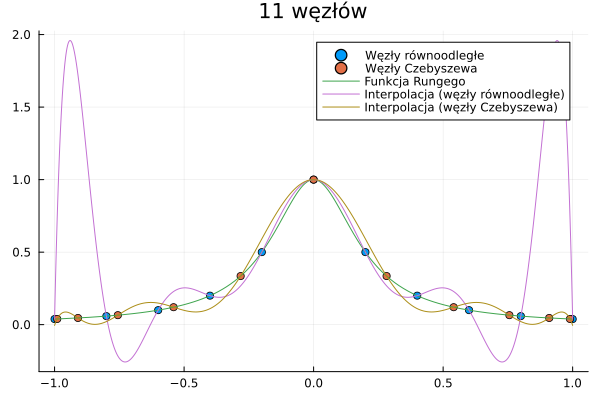

In [ ]:
using Plots
using Polynomials

func(x) = 1 / (1 + 25*x^2)

# Węzły równoodległe
xs =  range(-1, 1, length=11)
ys = func.(xs)
scatter(xs, ys, label="Węzły równoodległe")

# Węzły Czebyszewa
t11 = ChebyshevT([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
x_cheb = Polynomials.roots(t11)
y_cheb = func.(x_cheb)
scatter!(x_cheb, y_cheb, label="Węzły Czebyszewa")

plot!(func, label="Funkcja Rungego")
title!("11 węzłów")

# Wielomian interpolacyjny dla węzłów równoodległych
poly_nodes = fit(xs, ys)
x_range = range(-1, 1, length=1000)
y_nodes_interp = poly_nodes.(x_range)
plot!(x_range, y_nodes_interp, label="Interpolacja (węzły równoodległe)")

# Wielomian interpolacyjny dla węzłów Czebyszewa
poly_cheb = fit(x_cheb, y_cheb)
y_cheb_interp = poly_cheb.(x_range)
plot!(x_range, y_cheb_interp, label="Interpolacja (węzły Czebyszewa)")


### Zadanie 5
 
**(1 pkt)** Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ 

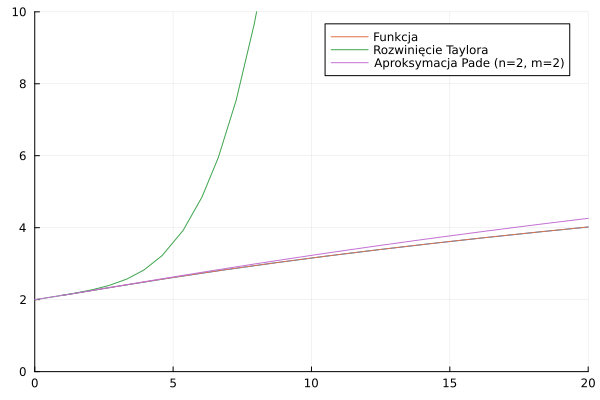

In [ ]:
using Plots
using Polynomials
using TaylorSeries

func(x) = (7 + (1 + x)^(4/3) )^(1/3)

xs = range(1, 20, length=11)
ys = func.(xs)
plot(xs, ys, label=false)

plot!(func, label="Funkcja", ylim=(0,10))

# Definiujemy, ile pierwszych wyrazów szeregu Taylora nas interesuje
t = Taylor1(Float64, 4)

# Rozwinięcie Taylora 
func_taylor = func(t)

# Z przybliżenia Taylora tworzymy wielomian zrozumiały dla pakietu Polynomials (typ Polynomial)
func_taylor_poly = Polynomial(func_taylor.coeffs)
plot!(func_taylor_poly, label="Rozwinięcie Taylora", xlim=(0,20))

# Aproksymacja Pade (dla n=2, m=2)
func_pade = Polynomials.PolyCompat.PadeApproximation.Pade(func_taylor_poly, 2, 2)

# Tworzymy funkcję z Polynomials
f_pade(x) = func_pade.p(x) / func_pade.q(x)

plot!(f_pade, label="Aproksymacja Pade (n=2, m=2)")
